In [1]:
import pandas as pd

# Sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

# Orm
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine

In [2]:
engine = create_engine('sqlite:///db.sqlite')
Session = sessionmaker(bind=engine)
session = Session()

df = pd.read_sql('LostItem', con = engine)

In [3]:
kept_features = ['date', 'type_objet']
df = df[kept_features]
df['cnt'] = 1

In [4]:
display(df,
df.dtypes)

,date,type_objet,cnt
0,2017-12-31T11:45:16+00:00,"Bagagerie: sacs, valises, cartables",1
1,2017-12-31T08:35:34+00:00,"Porte-monnaie / portefeuille, argent, titres",1
2,2017-12-31T08:28:26+00:00,Pièces d'identités et papiers personnels,1
3,2017-12-31T08:05:06+00:00,"Porte-monnaie / portefeuille, argent, titres",1
4,2017-12-31T07:58:14+00:00,"Bagagerie: sacs, valises, cartables",1
...,...,...,...
13885,2022-12-29T06:23:36+00:00,"Bagagerie: sacs, valises, cartables",1
13886,2022-12-28T17:08:22+00:00,"Articles d'enfants, de puériculture",1
13887,2022-12-28T16:17:18+00:00,Divers,1
13888,2022-12-28T08:52:56+00:00,"Bagagerie: sacs, valises, cartables",1


date          object
type_objet    object
cnt            int64
dtype: object

In [5]:
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day
df['date'] = pd.DatetimeIndex(df['date']).date

In [6]:
dfday = df.groupby(['year','month','day'])['cnt'].sum().reset_index()

In [7]:
dfday

,year,month,day,cnt
0,2017,12,3,8
1,2017,12,4,16
2,2017,12,5,14
3,2017,12,6,15
4,2017,12,7,14
...,...,...,...,...
1744,2022,12,31,10
1745,2023,1,1,4
1746,2023,1,2,9
1747,2023,1,3,7


In [8]:
# Training data
X = dfday.loc[:, ['year','month','day']]  # features
y = dfday.loc[:, 'cnt']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

In [9]:
y_pred

0       11.973205
1       11.957791
2       11.942377
3       11.926963
4       11.911549
          ...    
1744     5.246169
1745     4.220460
1746     4.205046
1747     4.189632
1748     4.174219
Length: 1749, dtype: float64

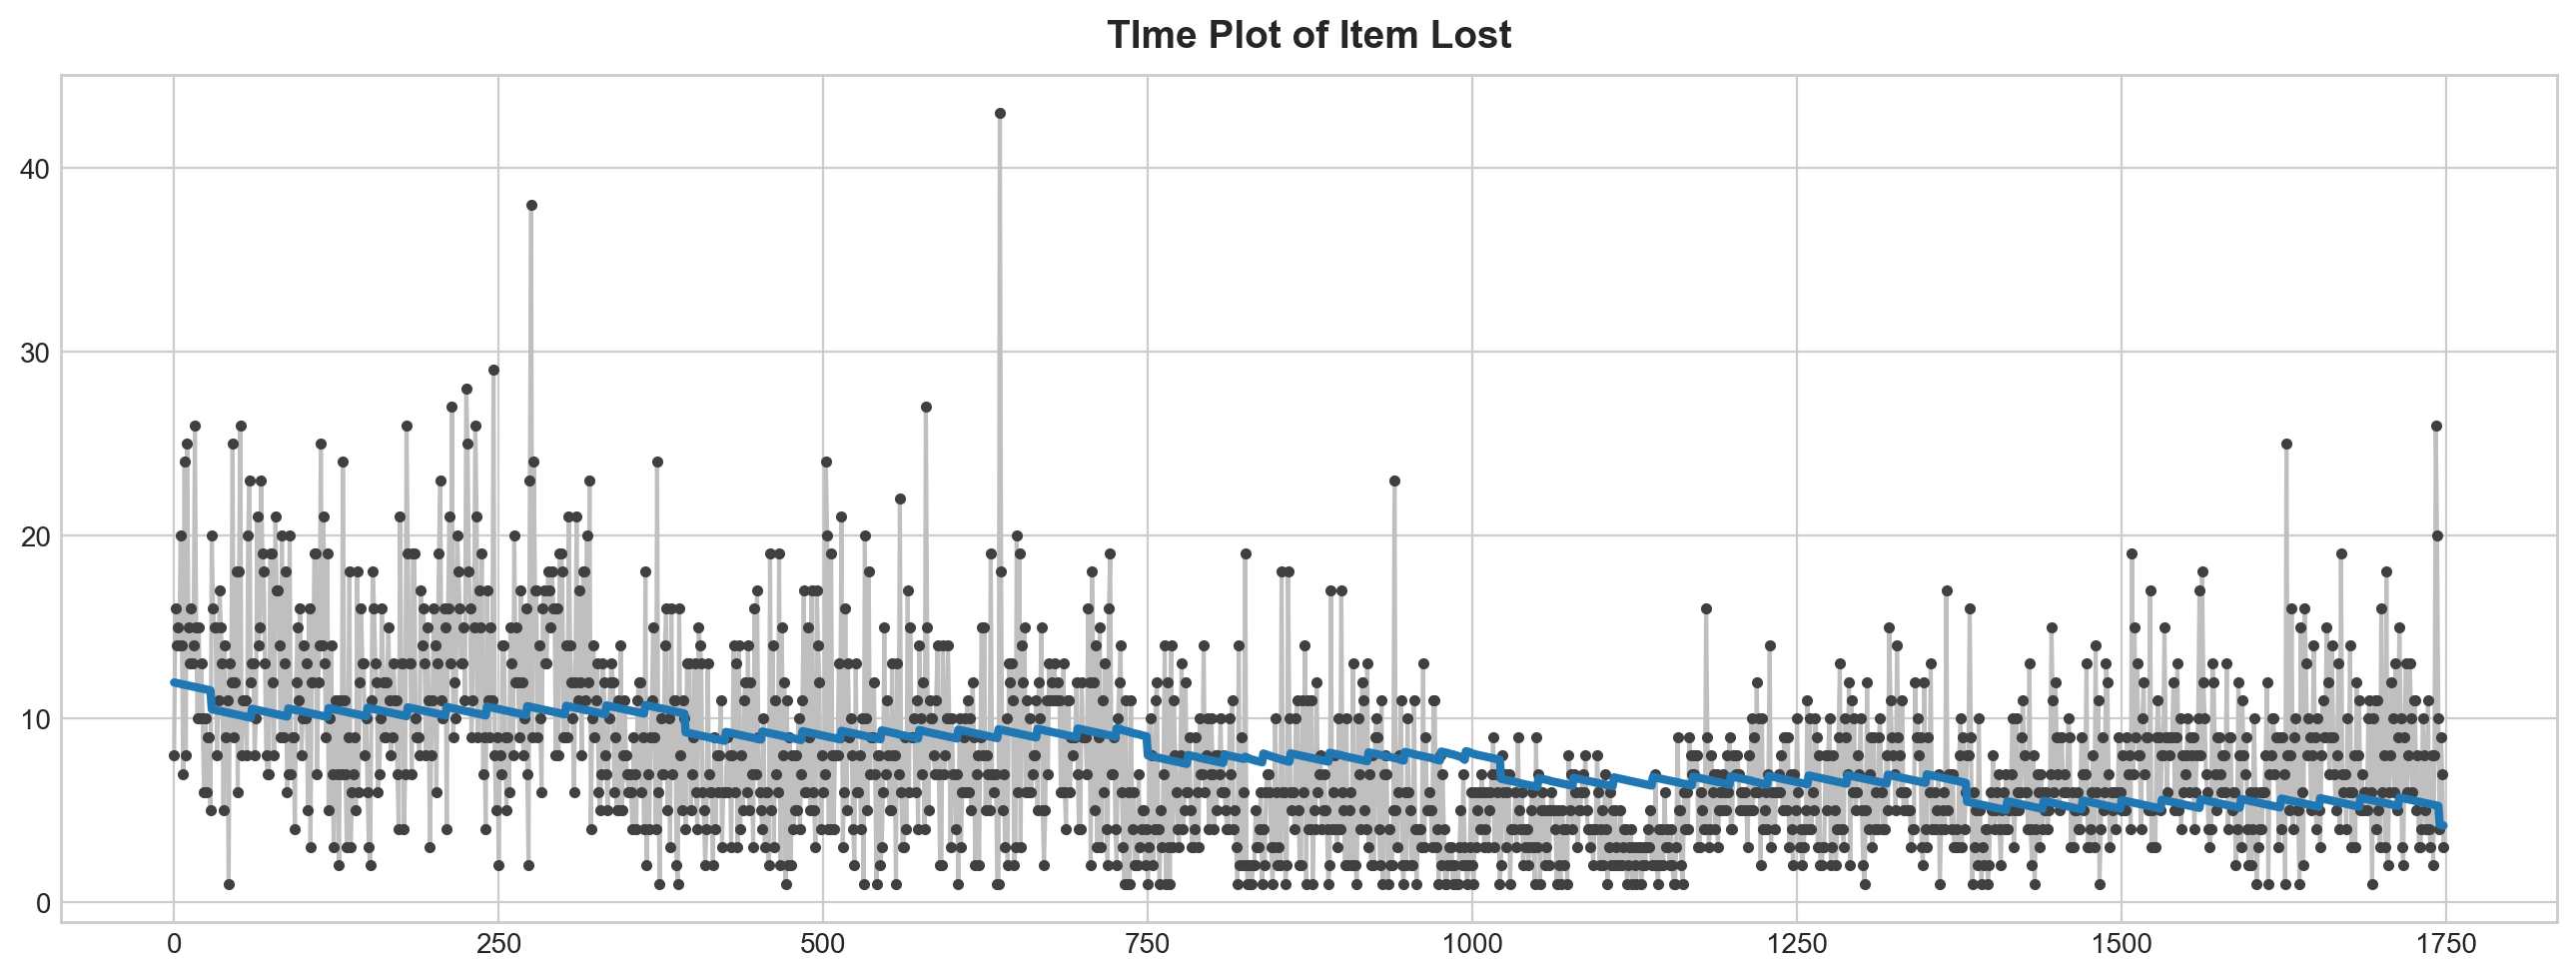

In [10]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")

plt.rc("figure", autolayout=True, figsize=(13, 5))

plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

%config InlineBackend.figure_format = 'retina'

ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('TIme Plot of Item Lost');

In [11]:
dfday['Lag_1'] = dfday['cnt'].shift(1)
dfday.head()

,year,month,day,cnt,Lag_1
0,2017,12,3,8,NaN
1,2017,12,4,16,8.0
2,2017,12,5,14,16.0
3,2017,12,6,15,14.0
4,2017,12,7,14,15.0


In [12]:
from sklearn.linear_model import LinearRegression

X = dfday.loc[:, ['Lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = dfday.loc[:, 'cnt']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

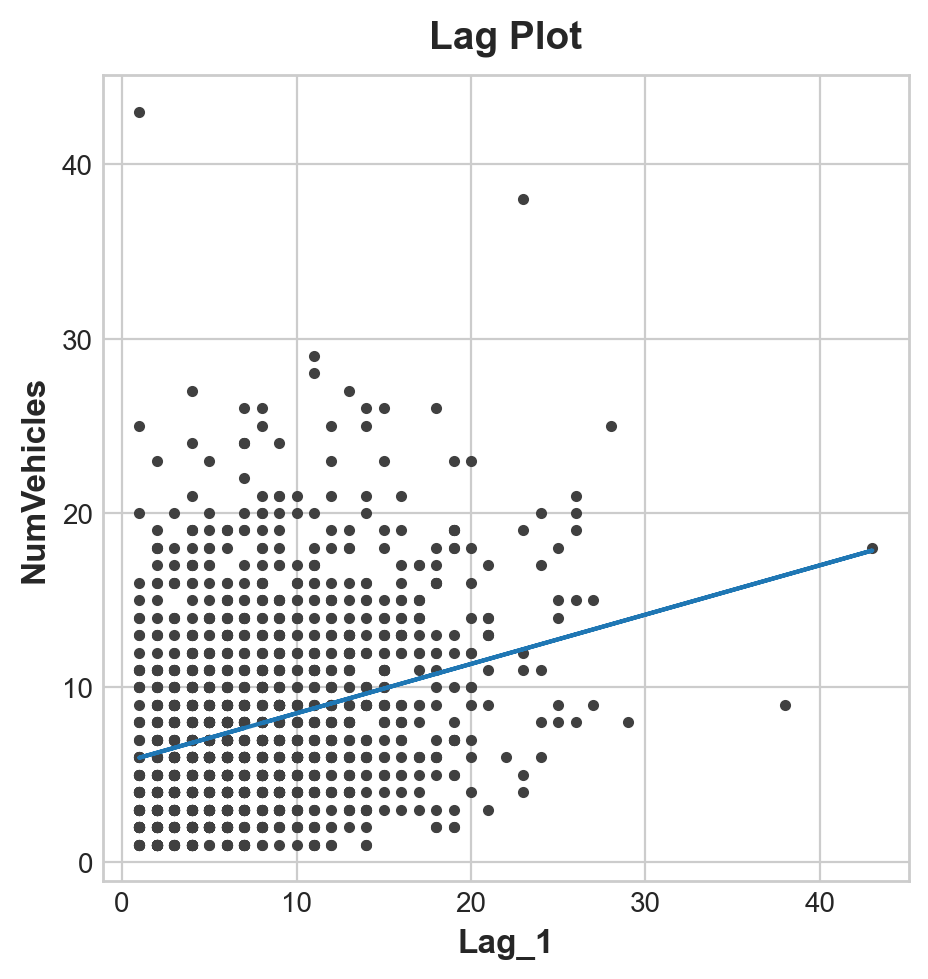

In [13]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('NumVehicles')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot');

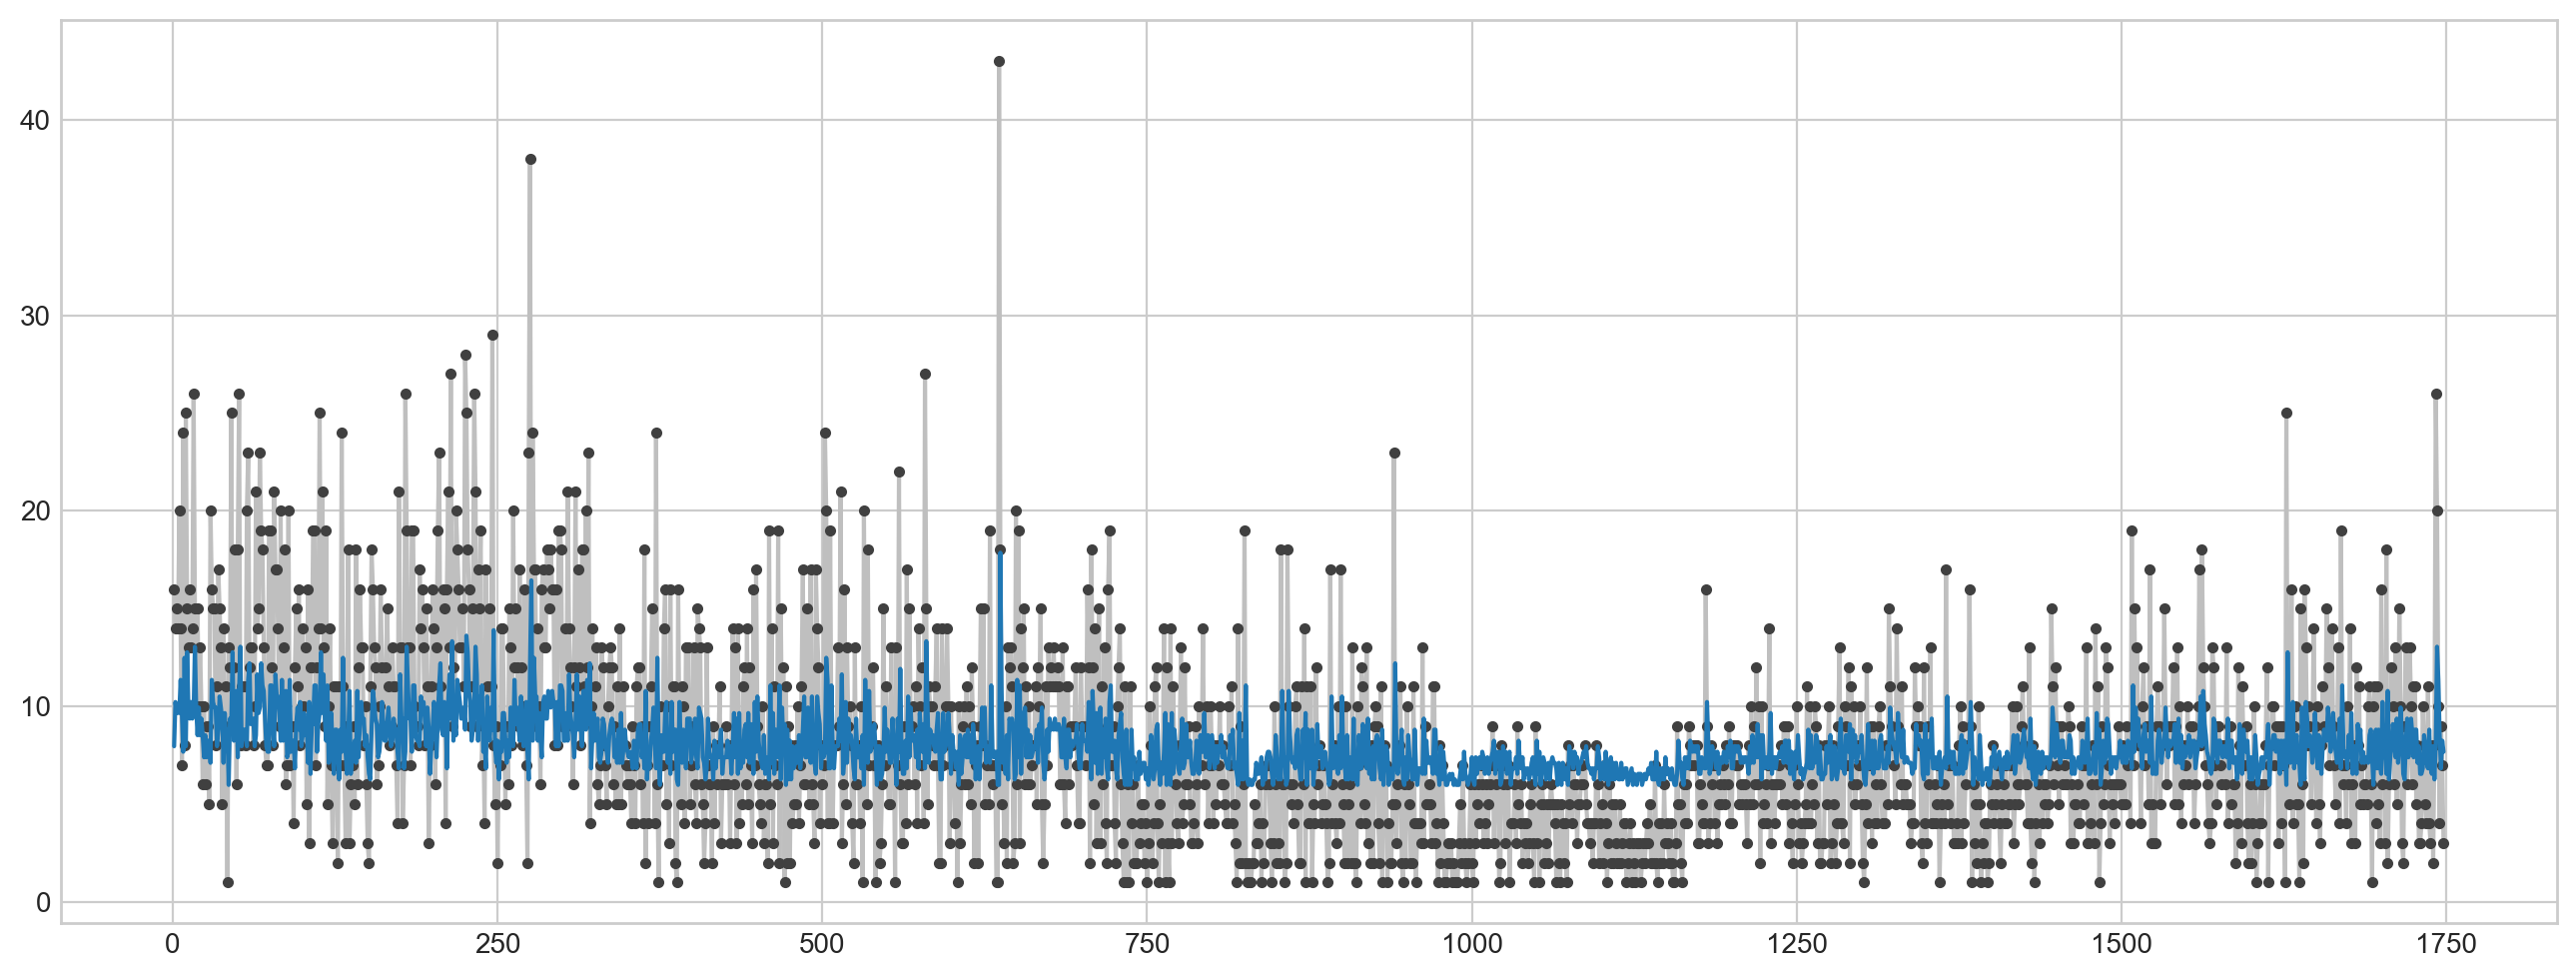

In [14]:
ax = y.plot(**plot_params)
ax = y_pred.plot()

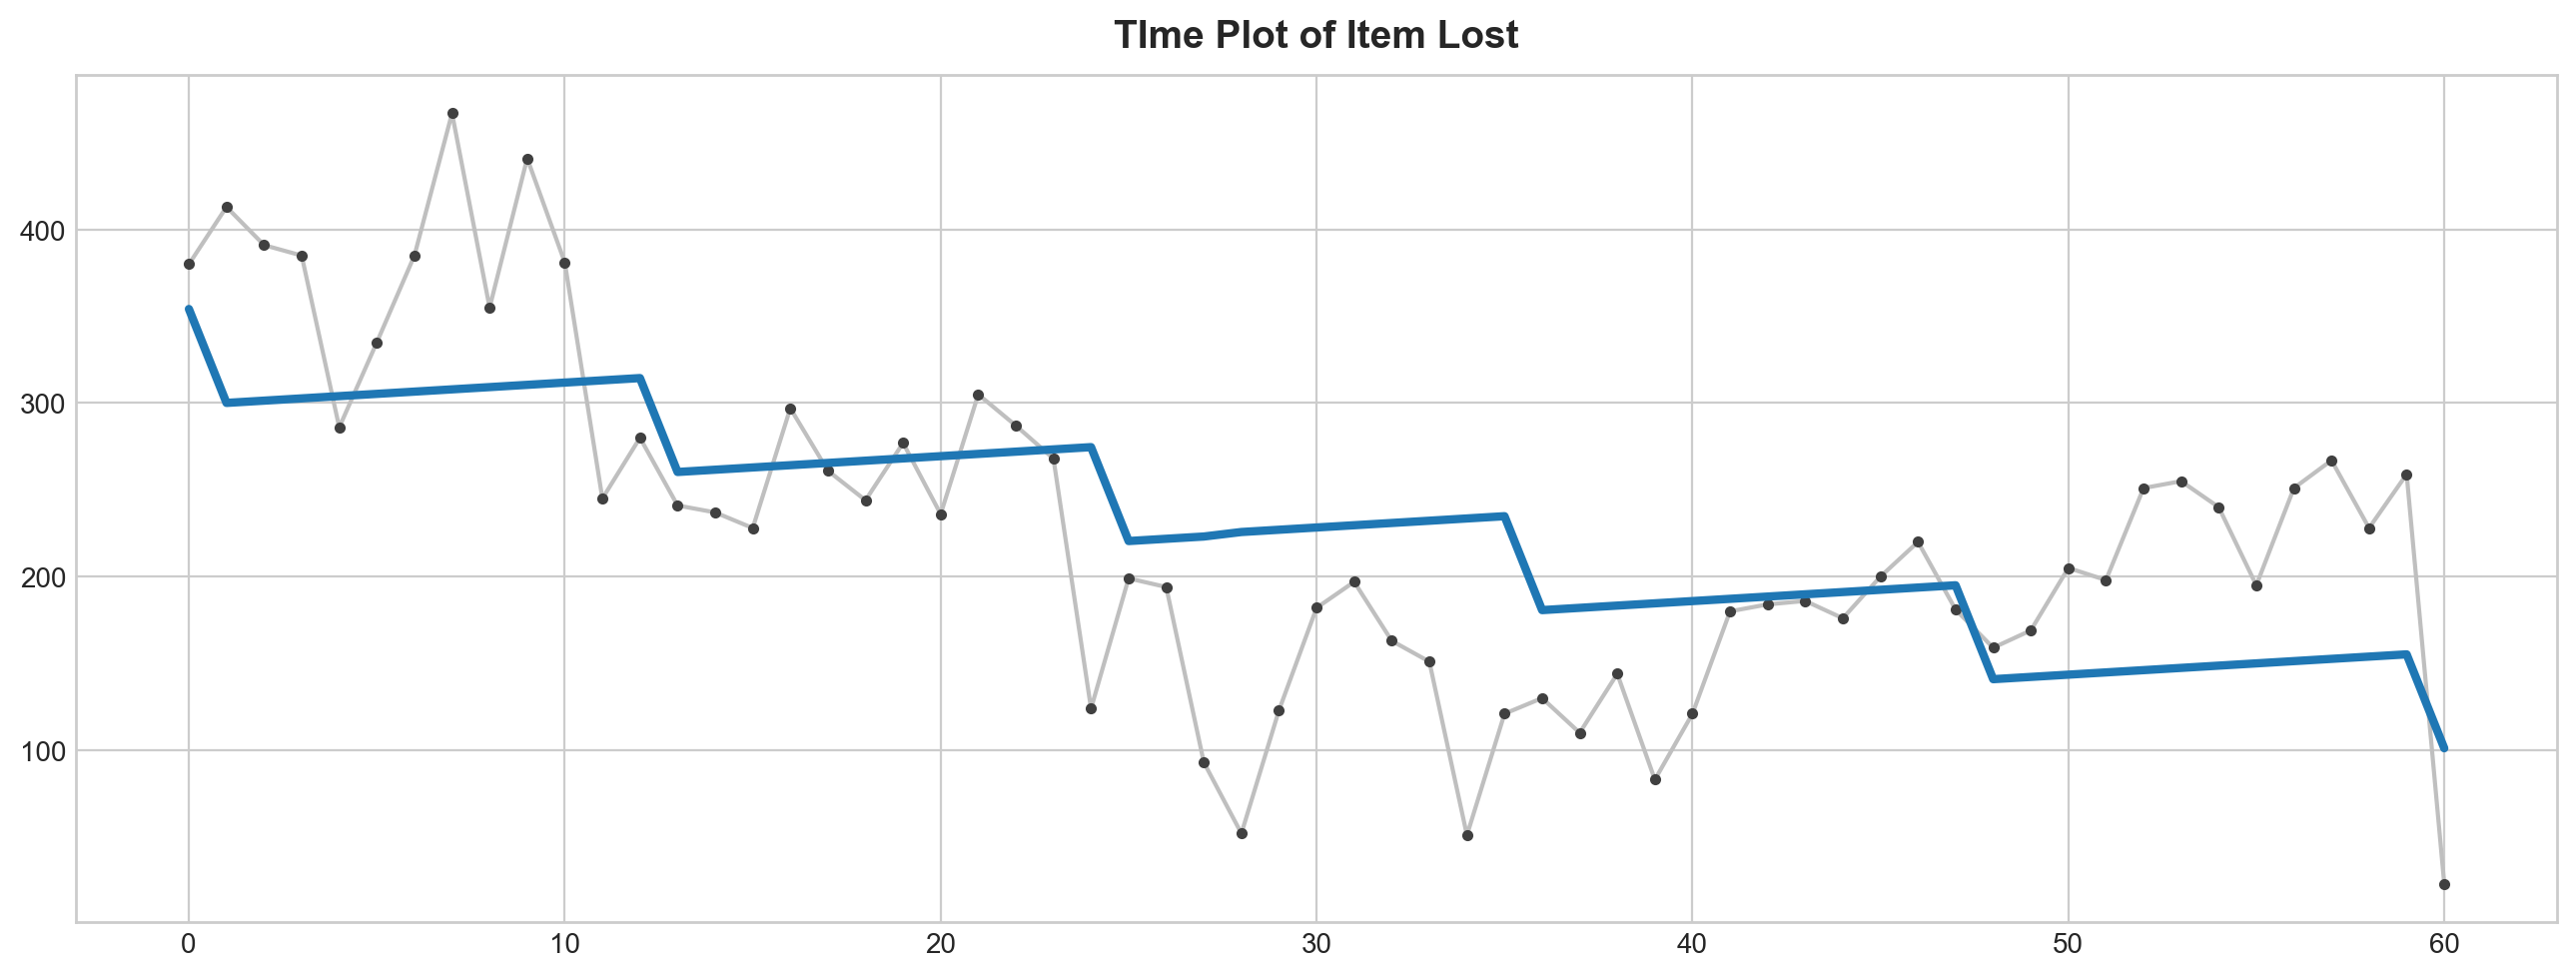

In [15]:
dfmonth = df.groupby(['year','month'])['cnt'].sum().reset_index()

# Training data
X = dfmonth.loc[:, ['year','month']]  # features
y = dfmonth.loc[:, 'cnt']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('TIme Plot of Item Lost');

In [16]:
dfmonth

,year,month,cnt
0,2017,12,380
1,2018,1,413
2,2018,2,391
3,2018,3,385
4,2018,4,286
...,...,...,...
56,2022,9,251
57,2022,10,267
58,2022,11,228
59,2022,12,259


In [17]:
dfmonth['Lag_1'] = dfmonth['cnt'].shift(1)
dfmonth.head()

,year,month,cnt,Lag_1
0,2017,12,380,NaN
1,2018,1,413,380.0
2,2018,2,391,413.0
3,2018,3,385,391.0
4,2018,4,286,385.0


In [18]:
from sklearn.linear_model import LinearRegression

X = dfmonth.loc[:, ['Lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = dfmonth.loc[:, 'cnt']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

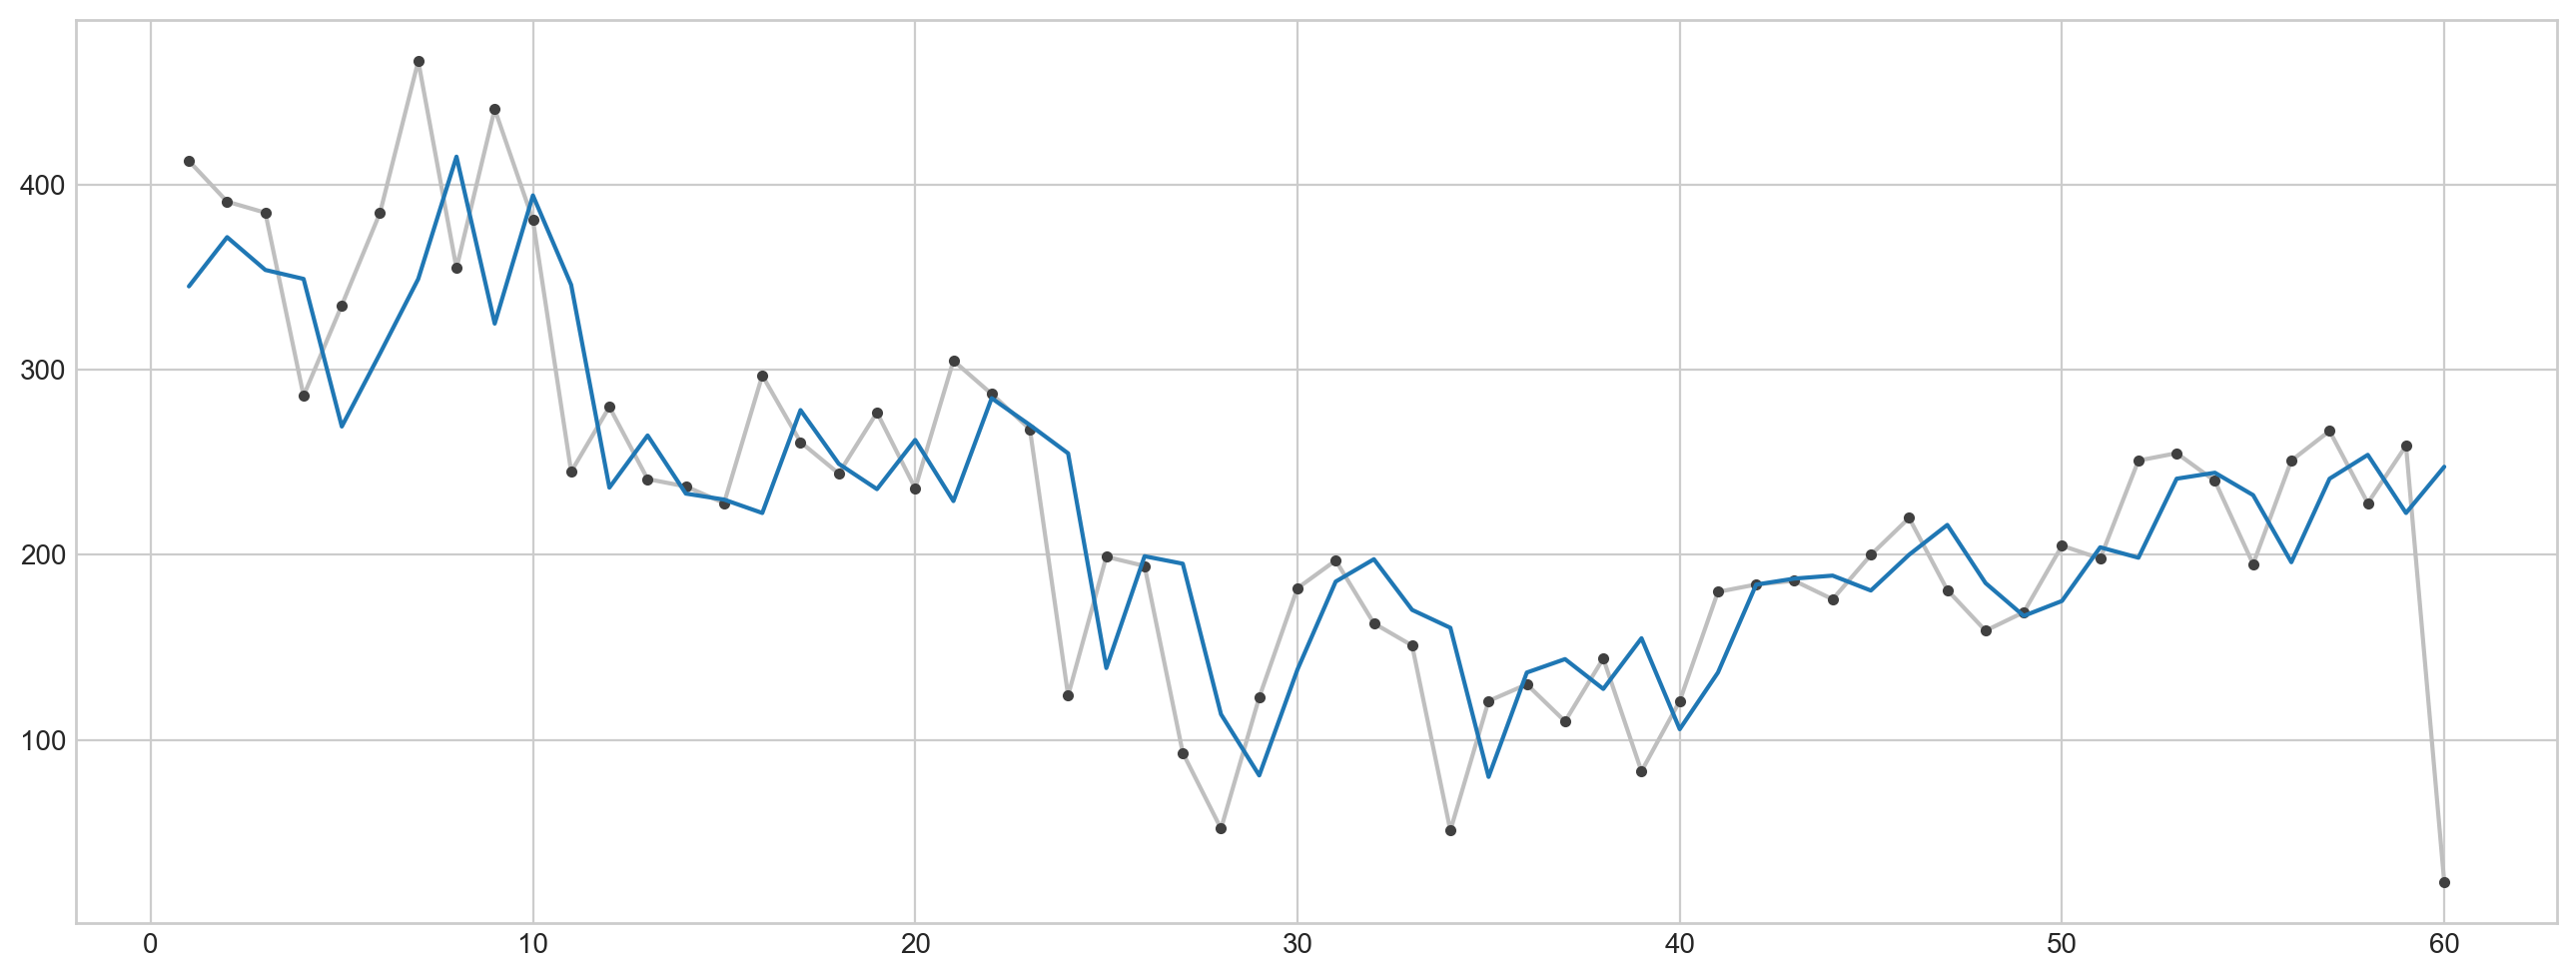

In [19]:
ax = y.plot(**plot_params)
ax = y_pred.plot()

In [21]:
import pmdarima as pm

stepwise_fit = pm.auto_arima(dfday[['cnt']], start_p=1, start_q=1,
                             max_p=3, max_q=3, m=12,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.05 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=12441.634, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=11439.285, Time=0.40 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.29 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=11966.206, Time=0.13 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=11246.546, Time=0.77 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=4.41 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.60 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=11751.117, Time=0.59 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=11056.155, Time=1.21 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=11241.342, Time=0.54 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=4.45 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.21 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=10949.073, Time=1.18 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AI

In [22]:
import pmdarima as pm

stepwise_fit = pm.auto_arima(dfmonth[['cnt']], start_p=1, start_q=1,
                            max_p=3, max_q=3, m=12,
                            start_P=0, seasonal=True,
                            d=1, D=1, trace=True,
                            error_action='ignore',  # don't want to know if an order does not work
                            suppress_warnings=True,  # don't want convergence warnings
                            stepwise=True, # set to stepwise
                            )  

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=545.451, Time=0.11 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=560.177, Time=0.11 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=550.781, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=543.962, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=553.768, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=545.488, Time=0.20 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=544.861, Time=0.21 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=547.007, Time=0.09 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.47 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=550.117, Time=0.07 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=545.273, Time=0.12 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=547.909, Time=0.14 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=546.675, Time=0.29 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=543.913, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   

In [23]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   61
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -267.956
Date:                            Thu, 05 Jan 2023   AIC                            543.913
Time:                                    13:55:59   BIC                            551.398
Sample:                                         0   HQIC                           546.741
                                             - 61                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.3494      2.208      1.517      0.129      -0.978       7.677
ma.L1         -0.6720      0.165     -4.085      0.000      -0.994      -0.350
ma.S.L12      -0.7958      0.618     -1.288      0.198      -2.006       0.415
sigma2      3266.2907   1782.490      1.832      0.067    -227.325    6759.906
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):                 4.61
Prob(Q):                              0.57   Prob(JB):                         0.10
Heteroskedasticity (H):               1.17   Skew:                            -0.60
Prob(H) (two-sided):                  0.76   Kurtosis:                         3.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
y_pred = stepwise_fit.predict(dfmonth.shape[0])

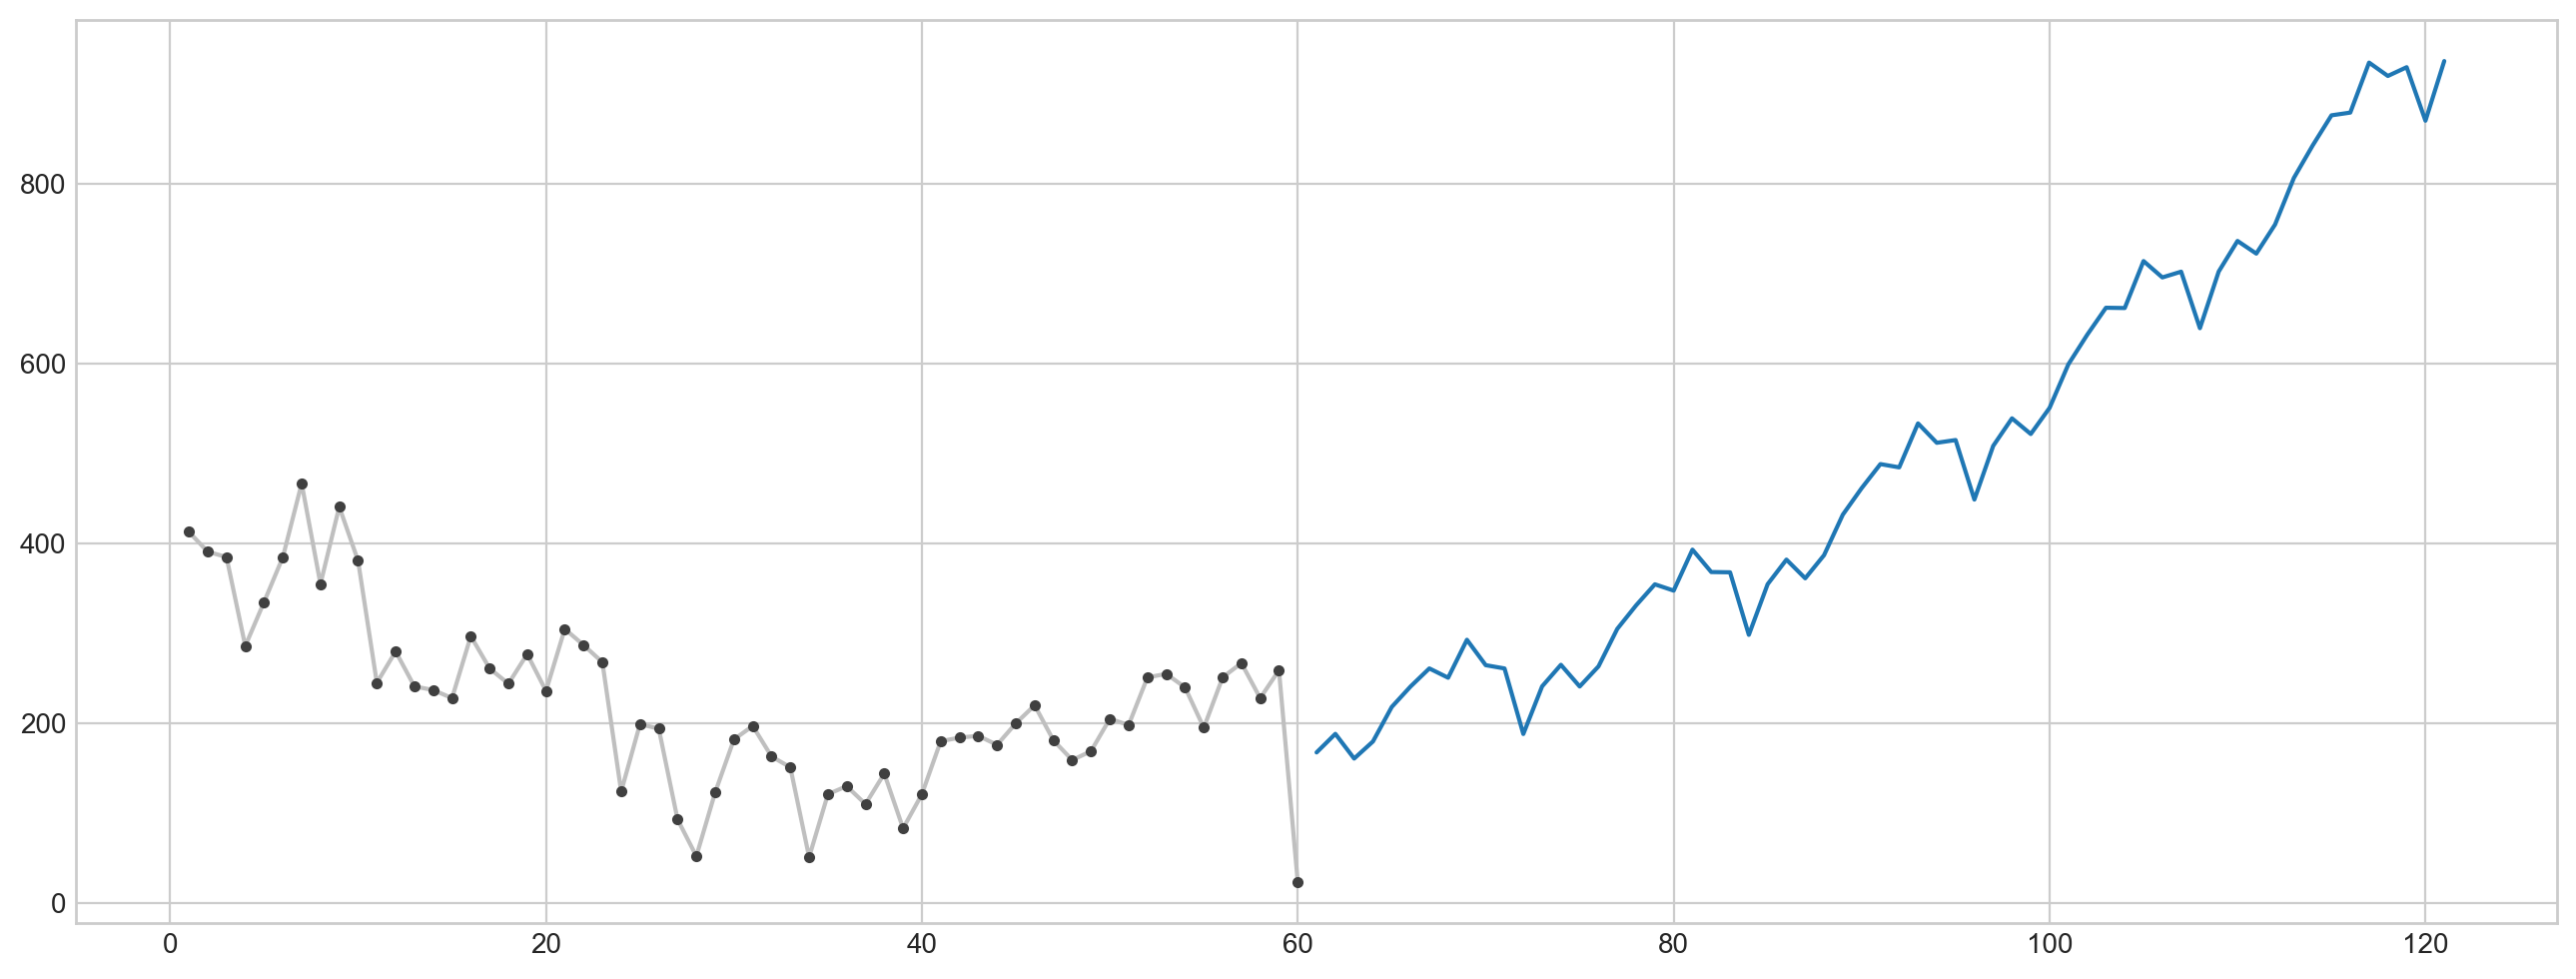

In [25]:
ax = y.plot(**plot_params)
ax = y_pred.plot()

In [26]:
pm.acf(dfmonth[['cnt']])

array([ 1.        ,  0.74538219,  0.64979156,  0.56931726,  0.52192616,
        0.50711064,  0.46884095,  0.43140057,  0.33595847,  0.35158186,
        0.29279177,  0.22870941,  0.20525565,  0.16510217,  0.11852279,
        0.08244771,  0.05874978, -0.06648111])

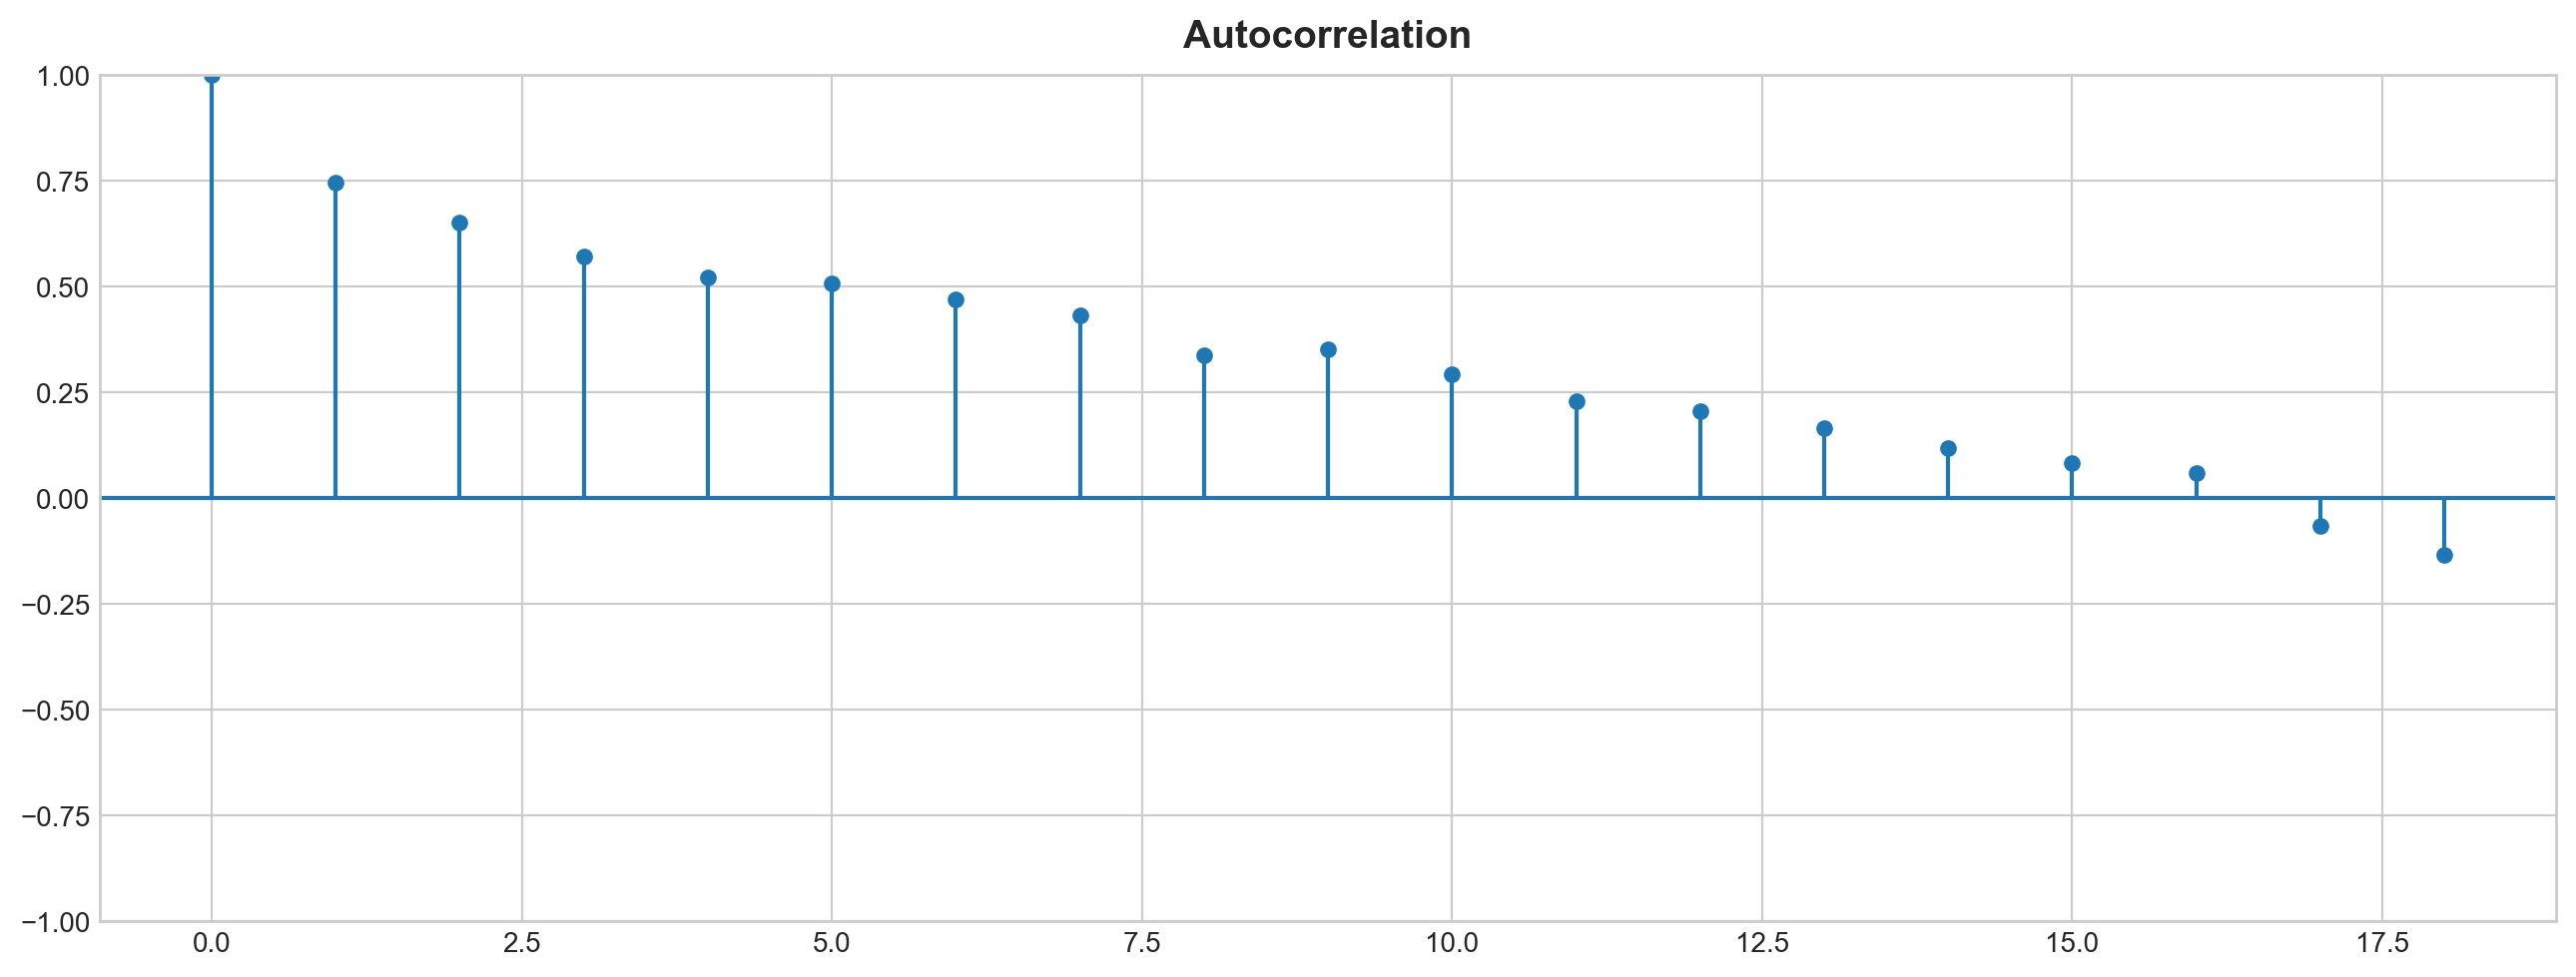

In [27]:
pm.plot_acf(dfmonth[['cnt']])

In [28]:
from statsmodels.tsa.api import SARIMAX, AutoReg
from statsmodels.tsa.arima.model import ARIMA

ar0_res = SARIMAX(dfmonth[['cnt']], order=(0, 0, 0), trend="c").fit()
sarimax_res = SARIMAX(dfmonth[['cnt']], order=(1, 0, 0), trend="c").fit()
arima_res = ARIMA(dfmonth[['cnt']], order=(1, 0, 0), trend="c").fit()
autoreg_res = AutoReg(dfmonth[['cnt']], 1, trend="c").fit()

In [29]:
intercept = [
    ar0_res.params[0],
    sarimax_res.params[0],
    arima_res.params[0],
    autoreg_res.params[0],
]
rho_hat = [0] + [r.params[1] for r in (sarimax_res, arima_res, autoreg_res)]
long_run = [
    ar0_res.params[0],
    sarimax_res.params[0] / (1 - sarimax_res.params[1]),
    arima_res.params[0],
    autoreg_res.params[0] / (1 - autoreg_res.params[1]),
]
cols = ["AR(0)", "SARIMAX", "ARIMA", "AutoReg"]
pd.DataFrame(
    [intercept, rho_hat, long_run],
    columns=cols,
    index=["delta-or-phi", "rho", "long-run mean"],
)

,AR(0),SARIMAX,ARIMA,AutoReg
delta-or-phi,227.704918,39.655266,224.232497,38.857423
rho,0.000000,0.823154,0.823147,0.806126
long-run mean,227.704918,224.236253,224.232497,200.426569


In [30]:
sarimax_exog_res = SARIMAX(dfmonth[['cnt']], exog=np.ones_like(dfmonth[['cnt']]), order=(1, 0, 0), trend="n").fit()
print(sarimax_exog_res.summary())

                               SARIMAX Results                                
Dep. Variable:                    cnt   No. Observations:                   61
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -336.144
Date:                Thu, 05 Jan 2023   AIC                            678.288
Time:                        13:56:00   BIC                            684.621
Sample:                             0   HQIC                           680.770
                                 - 61                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        224.2325     46.434      4.829      0.000     133.223     315.242
ar.L1          0.8231      0.089      9.279      0.000       0.649       0.997
sigma2      3514.6095    472.378      7.440      0.0

In [31]:
dfmonth

,year,month,cnt,Lag_1
0,2017,12,380,NaN
1,2018,1,413,380.0
2,2018,2,391,413.0
3,2018,3,385,391.0
4,2018,4,286,385.0
...,...,...,...,...
56,2022,9,251,195.0
57,2022,10,267,251.0
58,2022,11,228,267.0
59,2022,12,259,228.0


In [32]:
from sklearn.model_selection import TimeSeriesSplit

In [33]:
tss = TimeSeriesSplit(n_splits=5, test_size=None)
tss

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)

In [34]:
display(dfmonth.loc[:, ['year', 'month']].reset_index(),
dfmonth[['cnt']].reset_index())

,index,year,month
0,0,2017,12
1,1,2018,1
2,2,2018,2
3,3,2018,3
4,4,2018,4
...,...,...,...
56,56,2022,9
57,57,2022,10
58,58,2022,11
59,59,2022,12


,index,cnt
0,0,380
1,1,413
2,2,391
3,3,385
4,4,286
...,...,...
56,56,251
57,57,267
58,58,228
59,59,259


In [36]:
# First, let's split the time series into training and testing sets using TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit

X = dfmonth[['year', 'month']]
y = dfmonth['cnt']

tscv = TimeSeriesSplit(n_splits=6)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Next, let's import and initialize the XGBoost model
import xgboost as xgb

model = xgb.XGBRegressor()

# Now, let's fit the model to the training data
model.fit(X_train, y_train)

# And finally, let's make predictions on the test set and evaluate the model
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

print('mse: ', mean_squared_error(y_test, y_pred))
print('rmse: ', mean_squared_error(y_test, y_pred, squared=False))
print('mae: ', mean_absolute_error(y_test, y_pred))
print('mape: ', mean_absolute_percentage_error(y_test, y_pred))

mse:  2818.7251999961736
rmse:  53.09166789616025
mae:  34.165971755981445
mape:  0.8140735289865378
